<a href="https://colab.research.google.com/github/shinnew9/cse347-cse447RL/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


In [1]:
!pip install gymnasium

In [ ]:
"""
Starter code for Exercise (you can use this code, or extend your code from previous lab)
Implement SARSA with TD(5) on CliffWalking-v1
"""

import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

# Environment
env = gym.make("CliffWalking-v1")

# Parameters
n_states = env.observation_space.n
n_actions = env.action_space.n
alpha = 0.1           # step size (learning rate)
gamma = 0.99          # discount factor
epsilon = 0.1         # epsilon for epsilon-greedy policy
n_step = 5            # number of steps for TD(n)
n_episodes = 5000
max_steps = 200

# Initialize Q-table
Q = np.zeros((n_states, n_actions), dtype=np.float32)

def epsilon_greedy(state):
    """Choose an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return int(np.random.randint(n_actions))
    return int(np.argmax(Q[state]))


def moving_avg(x, w=50):
  x = np.asarray(x, dtype=float)
  if len(x) < w:
    return x
  return np.convolve(x, np.ones(w)/w, mode="valid")


# Track returns
episode_returns = []

for ep in range(n_episodes):
    state, _ = env.reset()
    action = epsilon_greedy(state)

    # Buffers to store the trajectory
    states = deque([int(state)])
    actions = deque([int(action)])
    rewards = deque([0.0])

    T = float("inf")
    t = 0
    G = 0
    done = False

    while True:
        if t < T:
            # Take real step in the environment
            s_t = states[-1]
            a_t = actions[-1]
            # r_t = rewards[-1]
            next_state, reward, terminated, truncated, _ = env.step(a_t)
            done = terminated or truncated

            # states.append(state)
            # actions.append(action)
            rewards.append(reward)

            if done:
                T = t + 1
            else:
                states.append(int(next_state))
                next_action = epsilon_greedy(next_state)
                actions.append(int(next_action))
                # next_action = epsilon_greedy(next_state)
                # state = next_state
                # action = next_action

        # Time index for state/action to update
        tau = t - n_step + 1
        if tau >= 0:
            # TODO: Compute the n-step return G for state tau
            # Hint: use rewards[tau : tau+n] plus Q(s_t+n, a_t+n) if not terminal

            # Example structure:
            G = 0.0
            upper = int(min(tau+ n_step, T))
            for k in range(tau +1, upper+1):
              G += (gamma ** (k - (tau+1))) * rewards[k]
            # accumulate discounted rewards
            # for i in range(tau, min(tau + n_step, T)):
                # G += (gamma ** (i - tau)) * rewards[i]
            if tau + n_step < T:
                s_tau_n = states[tau + n_step]
                a_tau_n = actions[tau + n_step]
                G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

            # TODO: Update Q[states[tau], actions[tau]] toward G
            # updating Q
            s_tau = states[tau]
            s_tau = states[tau]
            Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

        if tau == T - 1:
            break

        ep_return = float(np.sum(list(rewards)[1:int(T)+1])) if T != float("inf") else float(np.sum(list(rewards)[1:]))
        episode_returns.append(ep_return)


env.close()

# Plot learning curve
plt.figure(figsize=(10,4))
plt.plot(episode_returns, alpha=0.35, label="return per episode")
ma = moving_avg(episode_returns, 50)
if len(ma) > 0:
    plt.plot(range(49, 49+len(ma)), ma, lw=2, label="moving avg (w=50)")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title(f"SARSA with TD({n_step}) on CliffWalking")
plt.legend()
plt.tight_layout()
plt.show()

## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




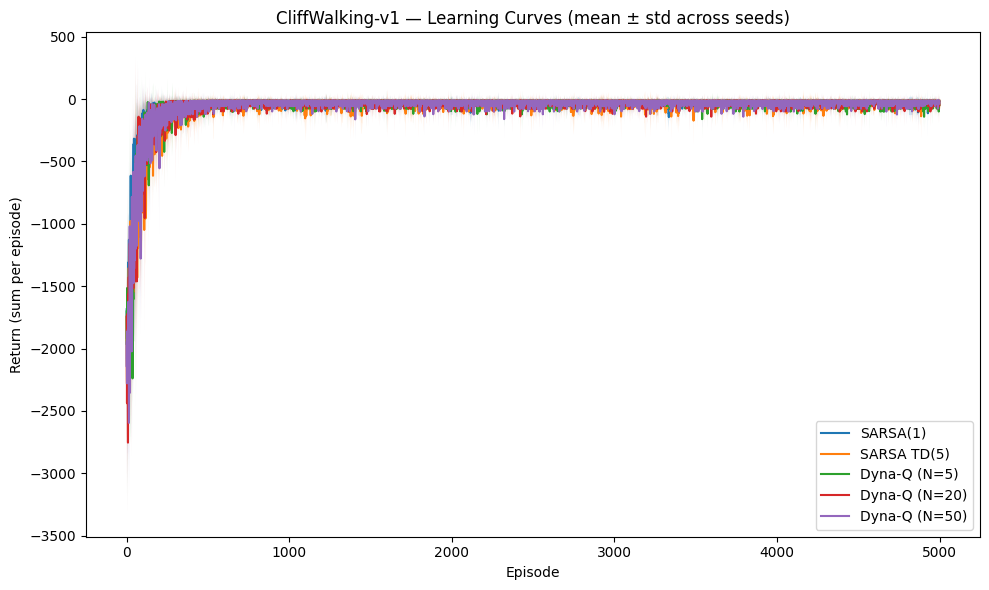

[threshold -30.0] SARSA(1): first episode where MA(100) > -30.0 = 575
[threshold -30.0] SARSA TD(5): first episode where MA(100) > -30.0 = 651
[threshold -30.0] Dyna-Q (N=5): first episode where MA(100) > -30.0 = 678
[threshold -30.0] Dyna-Q (N=20): first episode where MA(100) > -30.0 = 698
[threshold -30.0] Dyna-Q (N=50): first episode where MA(100) > -30.0 = 637


In [1]:
# ===========================================================
# Lab 4 — Dyna-Q vs SARSA(1) vs SARSA TD(5) on CliffWalking
# ===========================================================
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from collections import defaultdict

ENV_ID = "CliffWalking-v1"

# ------------- utilities -------------
def epsilon_greedy(Q, s, eps, nA, rng):
    if rng.random() < eps:
        return int(rng.integers(0, nA))
    return int(np.argmax(Q[s]))

def moving_avg(x, w=100):
    x = np.asarray(x, dtype=float)
    if len(x) < w: return x
    return np.convolve(x, np.ones(w)/w, mode="valid")

def find_threshold_episode(returns, window=100, threshold=-30.0):
    """
    returns: (episodes,) or (seeds, episodes) -> works on mean across axis 0 if 2D
    """
    arr = np.asarray(returns)
    if arr.ndim == 2:
        arr = arr.mean(axis=0)
    ma = moving_avg(arr, window)
    if len(ma) == 0: return None
    for i, v in enumerate(ma, start=window):  # ma[i-window] corresponds to episodes [i-window+1 .. i]
        if v > threshold:
            return i
    return None

# ------------- SARSA(1) -------------
def sarsa_1step(env_id=ENV_ID, episodes=5000, max_steps=200,
                alpha=0.5, gamma=0.99,
                eps_start=1.0, eps_end=0.05, eps_decay=0.995,
                seed=0):
    rng = np.random.default_rng(seed)
    env = gym.make(env_id)
    nA, nS = env.action_space.n, env.observation_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)

    eps = float(eps_start)
    ep_returns = []

    for ep in range(episodes):
        s, _ = env.reset(seed=int(rng.integers(0, 10_000)))
        a = epsilon_greedy(Q, s, eps, nA, rng)
        total = 0.0

        for t in range(max_steps):
            ns, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            total += r

            if done:
                target = r
            else:
                na = epsilon_greedy(Q, ns, eps, nA, rng)
                target = r + gamma * Q[ns, na]

            Q[s, a] += alpha * (target - Q[s, a])
            s, a = (ns, na) if not done else (ns, a)
            if done: break

        ep_returns.append(total)
        eps = max(eps_end, eps * eps_decay)

    env.close()
    return Q, np.array(ep_returns, dtype=np.float32)

# ------------- SARSA n-step (n=5) -------------
def sarsa_nstep(env_id=ENV_ID, n=5, episodes=5000, max_steps=200,
                alpha=0.5, gamma=0.99,
                eps_start=1.0, eps_end=0.05, eps_decay=0.995,
                seed=1):
    rng = np.random.default_rng(seed)
    env = gym.make(env_id)
    nA, nS = env.action_space.n, env.observation_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)

    eps = float(eps_start)
    ep_returns = []

    for ep in range(episodes):
        # index-based buffers (Sutton & Barto)
        S = [0]*(max_steps + n + 1)
        A = [0]*(max_steps + n + 1)
        R = [0.0]*(max_steps + n + 1)

        s, _ = env.reset(seed=int(rng.integers(0, 10_000)))
        S[0] = int(s)
        A[0] = epsilon_greedy(Q, S[0], eps, nA, rng)

        T = np.inf
        t = 0
        G_ep = 0.0

        while True:
            if t < T:
                ns, r, terminated, truncated, _ = env.step(A[t])
                done = terminated or truncated
                R[t+1] = r
                G_ep += r
                if done:
                    T = t + 1
                else:
                    S[t+1] = int(ns)
                    A[t+1] = epsilon_greedy(Q, S[t+1], eps, nA, rng)

            tau = t - n + 1
            if tau >= 0:
                # n-step return
                G = 0.0
                upper = int(min(tau + n, T))
                for k in range(tau+1, upper+1):
                    G += (gamma ** (k - (tau+1))) * R[k]
                if tau + n < T:
                    G += (gamma ** n) * Q[S[tau+n], A[tau+n]]
                Q[S[tau], A[tau]] += alpha * (G - Q[S[tau], A[tau]])

            if tau == T - 1:
                break
            t += 1
            if t >= max_steps + n:  # safety
                break

        ep_returns.append(G_ep)
        eps = max(eps_end, eps * eps_decay)

    env.close()
    return Q, np.array(ep_returns, dtype=np.float32)

# ------------- Dyna-Q -------------
def dyna_q(env_id=ENV_ID, planning_steps=20, episodes=5000, max_steps=200,
           alpha=0.5, gamma=0.99,
           eps_start=1.0, eps_end=0.05, eps_decay=0.995,
           seed=2):
    """
    Model: dict[(s,a)] -> list of (r, ns) outcomes (uniformly sampled)
    After each real step: do 'planning_steps' simulated Q-learning backups.
    """
    rng = np.random.default_rng(seed)
    env = gym.make(env_id)
    nA, nS = env.action_space.n, env.observation_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)

    # empirical model
    model = defaultdict(list)       # (s,a) -> list of (r, ns)
    seen_sa = []                    # list of seen (s,a) to sample from

    eps = float(eps_start)
    ep_returns = []

    for ep in range(episodes):
        s, _ = env.reset(seed=int(rng.integers(0, 10_000)))
        total = 0.0

        for t in range(max_steps):
            a = epsilon_greedy(Q, s, eps, nA, rng)
            ns, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            total += r

            # --- real Q-learning backup ---
            target = r if done else r + gamma * np.max(Q[ns])
            Q[s, a] += alpha * (target - Q[s, a])

            # --- model update ---
            key = (s, a)
            model[key].append((r, ns))       # store outcome (you could cap list len to limit memory)
            if key not in seen_sa:
                seen_sa.append(key)

            # --- planning (simulated) updates ---
            for _ in range(planning_steps):
                # sample a previously seen (s_p, a_p)
                s_p, a_p = seen_sa[int(rng.integers(0, len(seen_sa)))]
                # sample one of its recorded outcomes
                r_p, ns_p = model[(s_p, a_p)][int(rng.integers(0, len(model[(s_p, a_p)])))]
                # Q-learning backup on the simulated transition
                target_p = r_p + gamma * np.max(Q[ns_p])
                Q[s_p, a_p] += alpha * (target_p - Q[s_p, a_p])

            s = ns
            if done: break

        ep_returns.append(total)
        eps = max(eps_end, eps * eps_decay)

    env.close()
    return Q, np.array(ep_returns, dtype=np.float32)

# ------------- multi-seed runner -------------
def run_many(fn, seeds, **kwargs):
    """
    fn: training function returning (Q, returns)
    returns: (len(seeds), episodes) array of returns
    """
    outs = []
    for sd in seeds:
        _, rets = fn(seed=sd, **kwargs)
        outs.append(rets)
    # pad to same length (should be equal already)
    min_len = min(len(x) for x in outs)
    outs = np.stack([x[:min_len] for x in outs], axis=0)
    return outs  # shape: (S, E)

# ------------- plotting -------------
def plot_curves(mean_std_dict, title, ylabel="Return (sum per episode)"):
    """
    mean_std_dict: {label: (mean, std)} where mean,std are (episodes,)
    """
    plt.figure(figsize=(10,6))
    for label, (m, s) in mean_std_dict.items():
        x = np.arange(len(m))
        plt.plot(x, m, label=label)
        plt.fill_between(x, m - s, m + s, alpha=0.2)
    plt.xlabel("Episode")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------- main experiment -------------
if __name__ == "__main__":
    episodes   = 5000
    max_steps  = 200
    alpha      = 0.5
    gamma      = 0.99
    eps_start  = 1.0
    eps_end    = 0.05
    eps_decay  = 0.995
    seeds      = [0,1,2,3,4]    # ≥ 5 seeds

    # Baselines
    sarsa1_ret = run_many(
        sarsa_1step, seeds,
        env_id=ENV_ID, episodes=episodes, max_steps=max_steps,
        alpha=alpha, gamma=gamma,
        eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay
    )
    sarsa5_ret = run_many(
        sarsa_nstep, seeds,
        env_id=ENV_ID, n=5, episodes=episodes, max_steps=max_steps,
        alpha=alpha, gamma=gamma,
        eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay
    )

    # Dyna-Q with different planning steps
    dyna5_ret  = run_many(
        dyna_q, seeds,
        env_id=ENV_ID, planning_steps=5, episodes=episodes, max_steps=max_steps,
        alpha=alpha, gamma=gamma,
        eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay
    )
    dyna20_ret = run_many(
        dyna_q, seeds,
        env_id=ENV_ID, planning_steps=20, episodes=episodes, max_steps=max_steps,
        alpha=alpha, gamma=gamma,
        eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay
    )
    dyna50_ret = run_many(
        dyna_q, seeds,
        env_id=ENV_ID, planning_steps=50, episodes=episodes, max_steps=max_steps,
        alpha=alpha, gamma=gamma,
        eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay
    )

    # mean/std
    curves = {
        "SARSA(1)":  (sarsa1_ret.mean(axis=0),  sarsa1_ret.std(axis=0)),
        "SARSA TD(5)": (sarsa5_ret.mean(axis=0), sarsa5_ret.std(axis=0)),
        "Dyna-Q (N=5)":  (dyna5_ret.mean(axis=0),  dyna5_ret.std(axis=0)),
        "Dyna-Q (N=20)": (dyna20_ret.mean(axis=0), dyna20_ret.std(axis=0)),
        "Dyna-Q (N=50)": (dyna50_ret.mean(axis=0), dyna50_ret.std(axis=0)),
    }
    plot_curves(curves, "CliffWalking-v1 — Learning Curves (mean ± std across seeds)")

    # Sample efficiency (threshold crossing)
    THRESH = -30.0
    for name, ret in [
        ("SARSA(1)", sarsa1_ret),
        ("SARSA TD(5)", sarsa5_ret),
        ("Dyna-Q (N=5)", dyna5_ret),
        ("Dyna-Q (N=20)", dyna20_ret),
        ("Dyna-Q (N=50)", dyna50_ret),
    ]:
        N = find_threshold_episode(ret, window=100, threshold=THRESH)
        print(f"[threshold {THRESH}] {name}: first episode where MA(100) > {THRESH} = {N}")


## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).


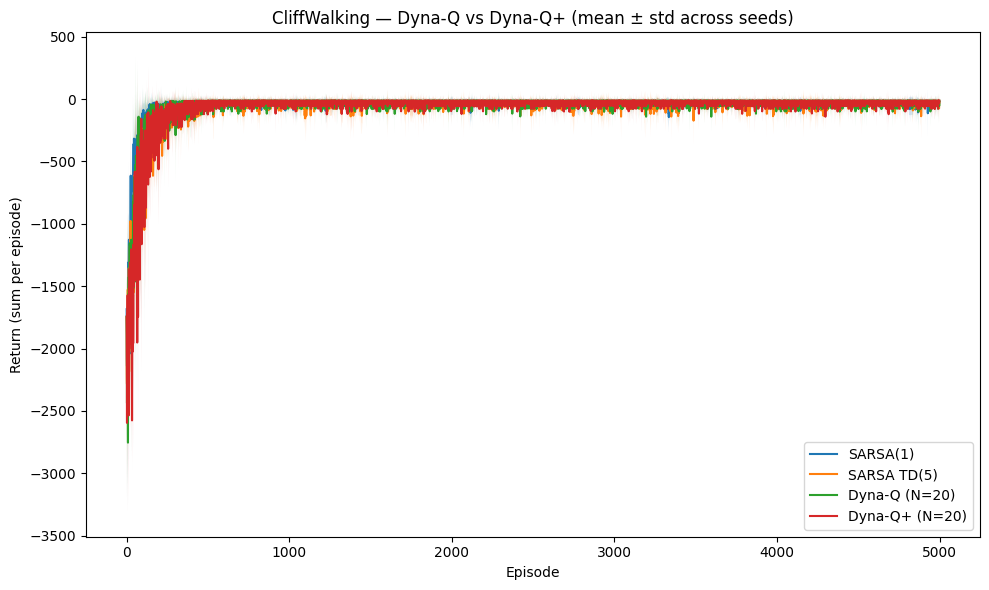

[threshold -30.0] SARSA(1): first episode where MA(100) > -30.0 = 575
[threshold -30.0] SARSA TD(5): first episode where MA(100) > -30.0 = 651
[threshold -30.0] Dyna-Q (N=20): first episode where MA(100) > -30.0 = 698
[threshold -30.0] Dyna-Q+ (N=20): first episode where MA(100) > -30.0 = 632


In [2]:
# =========================
# Exercise 3 — Dyna-Q+ (CliffWalking-v1)
# =========================
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from collections import defaultdict

ENV_ID = "CliffWalking-v1"

# utils
def epsilon_greedy(Q, s, eps, nA, rng):
    if rng.random() < eps:
        return int(rng.integers(0, nA))
    return int(np.argmax(Q[s]))

def moving_avg(x, w=100):
    x = np.asarray(x, dtype=float)
    if len(x) < w: return x
    return np.convolve(x, np.ones(w)/w, mode="valid")

def find_threshold_episode(returns, window=100, threshold=-30.0):
    arr = np.asarray(returns)
    if arr.ndim == 2:  # seeds x episodes
        arr = arr.mean(axis=0)
    ma = moving_avg(arr, window)
    if len(ma) == 0: return None
    for i, v in enumerate(ma, start=window):
        if v > threshold:
            return i
    return None

def plot_curves(mean_std_dict, title, ylabel="Return (sum per episode)"):
    plt.figure(figsize=(10,6))
    for label, (m, s) in mean_std_dict.items():
        x = np.arange(len(m))
        plt.plot(x, m, label=label)
        plt.fill_between(x, m - s, m + s, alpha=0.2)
    plt.xlabel("Episode"); plt.ylabel(ylabel)
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

# baselines
def sarsa_1step(env_id=ENV_ID, episodes=5000, max_steps=200,
                alpha=0.5, gamma=0.99,
                eps_start=1.0, eps_end=0.05, eps_decay=0.995,
                seed=0):
    rng = np.random.default_rng(seed)
    env = gym.make(env_id)
    nA, nS = env.action_space.n, env.observation_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)
    eps = float(eps_start)
    ep_returns = []

    for ep in range(episodes):
        s, _ = env.reset(seed=int(rng.integers(0, 10_000)))
        a = epsilon_greedy(Q, s, eps, nA, rng)
        total = 0.0
        for _ in range(max_steps):
            ns, r, term, trunc, _ = env.step(a)
            done = term or trunc
            total += r
            if done: target = r
            else:
                na = epsilon_greedy(Q, ns, eps, nA, rng)
                target = r + gamma * Q[ns, na]
            Q[s, a] += alpha * (target - Q[s, a])
            s, a = (ns, na) if not done else (ns, a)
            if done: break
        ep_returns.append(total)
        eps = max(eps_end, eps * eps_decay)
    env.close()
    return Q, np.array(ep_returns, dtype=np.float32)

def sarsa_nstep(env_id=ENV_ID, n=5, episodes=5000, max_steps=200,
                alpha=0.5, gamma=0.99,
                eps_start=1.0, eps_end=0.05, eps_decay=0.995,
                seed=1):
    rng = np.random.default_rng(seed)
    env = gym.make(env_id)
    nA, nS = env.action_space.n, env.observation_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)
    eps = float(eps_start)
    ep_returns = []
    for ep in range(episodes):
        S = [0]*(max_steps+n+1); A=[0]*(max_steps+n+1); R=[0.0]*(max_steps+n+1)
        s, _ = env.reset(seed=int(rng.integers(0, 10_000)))
        S[0] = int(s); A[0] = epsilon_greedy(Q, S[0], eps, nA, rng)
        T = np.inf; t = 0; G_ep = 0.0
        while True:
            if t < T:
                ns, r, term, trunc, _ = env.step(A[t])
                done = term or trunc; R[t+1] = r; G_ep += r
                if done: T = t+1
                else:
                    S[t+1] = int(ns); A[t+1] = epsilon_greedy(Q, S[t+1], eps, nA, rng)
            tau = t - n + 1
            if tau >= 0:
                G = 0.0
                upper = int(min(tau+n, T))
                for k in range(tau+1, upper+1):
                    G += (gamma ** (k-(tau+1))) * R[k]
                if tau + n < T:
                    G += (gamma ** n) * Q[S[tau+n], A[tau+n]]
                Q[S[tau], A[tau]] += alpha * (G - Q[S[tau], A[tau]])
            if tau == T - 1: break
            t += 1
            if t >= max_steps + n: break
        ep_returns.append(G_ep)
        eps = max(eps_end, eps * eps_decay)
    env.close()
    return Q, np.array(ep_returns, dtype=np.float32)

# Dyna-Q (basis)
def dyna_q(env_id=ENV_ID, planning_steps=20, episodes=5000, max_steps=200,
           alpha=0.5, gamma=0.99,
           eps_start=1.0, eps_end=0.05, eps_decay=0.995,
           seed=2):
    rng = np.random.default_rng(seed)
    env = gym.make(env_id)
    nA, nS = env.action_space.n, env.observation_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)
    model = defaultdict(list)
    seen_sa = []
    eps = float(eps_start)
    ep_returns = []
    for ep in range(episodes):
        s, _ = env.reset(seed=int(rng.integers(0, 10_000)))
        total = 0.0
        for _ in range(max_steps):
            a = epsilon_greedy(Q, s, eps, nA, rng)
            ns, r, term, trunc, _ = env.step(a)
            done = term or trunc; total += r
            # real update
            target = r if done else r + gamma * np.max(Q[ns])
            Q[s, a] += alpha * (target - Q[s, a])
            # model
            key = (s, a)
            model[key].append((r, ns))
            if key not in seen_sa: seen_sa.append(key)
            # planning
            for _ in range(planning_steps):
                s_p, a_p = seen_sa[int(rng.integers(0, len(seen_sa)))]
                r_p, ns_p = model[(s_p, a_p)][int(rng.integers(0, len(model[(s_p, a_p)])))]
                target_p = r_p + gamma * np.max(Q[ns_p])
                Q[s_p, a_p] += alpha * (target_p - Q[s_p, a_p])
            s = ns
            if done: break
        ep_returns.append(total)
        eps = max(eps_end, eps * eps_decay)
    env.close()
    return Q, np.array(ep_returns, dtype=np.float32)

# Dyna-Q+ (탐사 보너스)
def dyna_q_plus(env_id=ENV_ID, planning_steps=20, episodes=5000, max_steps=200,
                alpha=0.5, gamma=0.99, kappa=0.001,
                eps_start=1.0, eps_end=0.05, eps_decay=0.995,
                seed=3):
    """
    보너스: bonus(s,a) = kappa * sqrt( time_since_last_visit(s,a) )
    - real step에는 일반 Q-learning(보너스 없음)
    - planning step에서 model 보상에 bonus를 더함
    """
    rng = np.random.default_rng(seed)
    env = gym.make(env_id)
    nA, nS = env.action_space.n, env.observation_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)

    model = defaultdict(list)  # (s,a) -> [(r, ns), ...]
    seen_sa = []
    last_visit = np.zeros((nS, nA), dtype=np.int64)  # 마지막 방문 에피소드 시각(또는 스텝 시각)
    t_global = 0  # 전체 스텝 카운터(보너스의 Δt 정의용)

    eps = float(eps_start)
    ep_returns = []

    for ep in range(episodes):
        s, _ = env.reset(seed=int(rng.integers(0, 10_000)))
        total = 0.0
        for _ in range(max_steps):
            t_global += 1
            a = epsilon_greedy(Q, s, eps, nA, rng)
            ns, r, term, trunc, _ = env.step(a)
            done = term or trunc; total += r

            # real Q-learning update (no bonus)
            target = r if done else r + gamma * np.max(Q[ns])
            Q[s, a] += alpha * (target - Q[s, a])

            # update model + timestamp
            key = (s, a)
            model[key].append((r, ns))
            if key not in seen_sa: seen_sa.append(key)
            last_visit[s, a] = t_global

            # planning with exploration bonus
            for _ in range(planning_steps):
                s_p, a_p = seen_sa[int(rng.integers(0, len(seen_sa)))]
                # time since last tried
                tau = max(1, t_global - last_visit[s_p, a_p])
                bonus = kappa * np.sqrt(tau)

                r_p, ns_p = model[(s_p, a_p)][int(rng.integers(0, len(model[(s_p, a_p)])))]
                r_p_bonus = r_p + bonus
                target_p = r_p_bonus + gamma * np.max(Q[ns_p])
                Q[s_p, a_p] += alpha * (target_p - Q[s_p, a_p])

            s = ns
            if done: break

        ep_returns.append(total)
        eps = max(eps_end, eps * eps_decay)

    env.close()
    return Q, np.array(ep_returns, dtype=np.float32)

# multi-seed runner
def run_many(fn, seeds, **kwargs):
    outs = []
    for sd in seeds:
        _, rets = fn(seed=sd, **kwargs)
        outs.append(rets)
    min_len = min(len(x) for x in outs)
    outs = np.stack([x[:min_len] for x in outs], axis=0)
    return outs

#  main: compare Dyna-Q vs Dyna-Q+ and baselines
if __name__ == "__main__":
    episodes   = 5000
    max_steps  = 200
    alpha      = 0.5
    gamma      = 0.99
    eps_start  = 1.0
    eps_end    = 0.05
    eps_decay  = 0.995
    seeds      = [0,1,2,3,4]
    THRESH     = -30.0

    # baselines
    ret_sarsa1 = run_many(sarsa_1step, seeds, episodes=episodes, max_steps=max_steps,
                          alpha=alpha, gamma=gamma, eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)
    ret_sarsa5 = run_many(sarsa_nstep, seeds, n=5, episodes=episodes, max_steps=max_steps,
                          alpha=alpha, gamma=gamma, eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)

    # Dyna-Q family
    ret_dyna20  = run_many(dyna_q, seeds, planning_steps=20, episodes=episodes, max_steps=max_steps,
                           alpha=alpha, gamma=gamma, eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)
    ret_dqplus20= run_many(dyna_q_plus, seeds, planning_steps=20, episodes=episodes, max_steps=max_steps,
                           alpha=alpha, gamma=gamma, kappa=0.001,
                           eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)

    # curves
    curves = {
        "SARSA(1)":        (ret_sarsa1.mean(axis=0),  ret_sarsa1.std(axis=0)),
        "SARSA TD(5)":     (ret_sarsa5.mean(axis=0),  ret_sarsa5.std(axis=0)),
        "Dyna-Q (N=20)":   (ret_dyna20.mean(axis=0),  ret_dyna20.std(axis=0)),
        "Dyna-Q+ (N=20)":  (ret_dqplus20.mean(axis=0),ret_dqplus20.std(axis=0)),
    }
    plot_curves(curves, "CliffWalking — Dyna-Q vs Dyna-Q+ (mean ± std across seeds)")

    # sample efficiency (threshold crossing)
    for name, ret in [
        ("SARSA(1)", ret_sarsa1),
        ("SARSA TD(5)", ret_sarsa5),
        ("Dyna-Q (N=20)", ret_dyna20),
        ("Dyna-Q+ (N=20)", ret_dqplus20),
    ]:
        N = find_threshold_episode(ret, window=100, threshold=THRESH)
        print(f"[threshold {THRESH}] {name}: first episode where MA(100) > {THRESH} = {N}")
